# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [2]:
!pip install sagemaker==1.72.0

# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import boto3
import sagemaker
pd.set_option('display.max_colwidth', 100)

# magic word for producing visualizations in notebook
%matplotlib inline

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p36/bin/python -m pip install --upgrade pip' command.


In [3]:
# session and role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

# create an S3 bucket
bucket = sagemaker_session.default_bucket()

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [4]:
genpop_file = 'Udacity_AZDIAS_052018.csv'
cust_file = 'Udacity_CUSTOMERS_052018.csv'
train_file = 'Udacity_MAILOUT_052018_TRAIN.csv'
test_file = 'Udacity_MAILOUT_052018_TEST.csv'

In [5]:
def read_file(filename):
    return pd.read_csv('s3://{}/{}'.format(bucket, filename), sep = ';')

In [6]:
%%time

genpop = read_file(genpop_file)
customers = read_file(cust_file)
train = read_file(train_file)
test = read_file(test_file)

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/IPython/core/magic.py:187: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  call = lambda f, *a, **k: f(*a, **k)


CPU times: user 35.8 s, sys: 3.01 s, total: 38.8 s
Wall time: 1min 8s


First we need to answer the following questions:

- how much data is missing in each column?
- which columns are irredeemable and need to removed
- which columns with missing data will we keep but fill in their NaNs
- which are the final columns that we will use PCA on

In [11]:
datasets = {
    'genpop':genpop,
    'customers':customers,
    'train':train,
    'test':test
}

In [12]:
def count_na(df):
    '''
    Counts the number of missing values of each column as a percentage
    '''
    series = df.isna().sum()/len(df)
    return series

Visualizing how many missing values we have to deal with and if their distribution is the same across other datasets

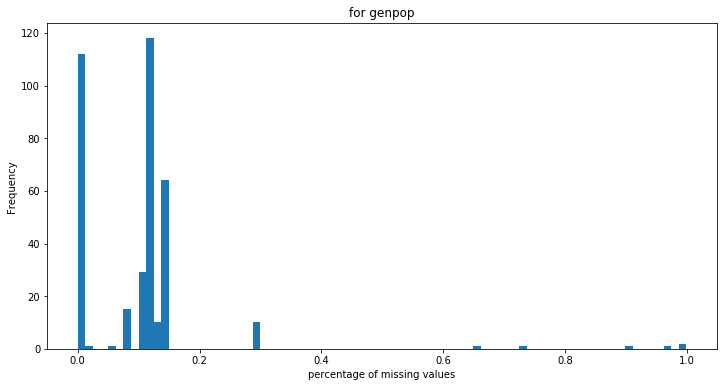

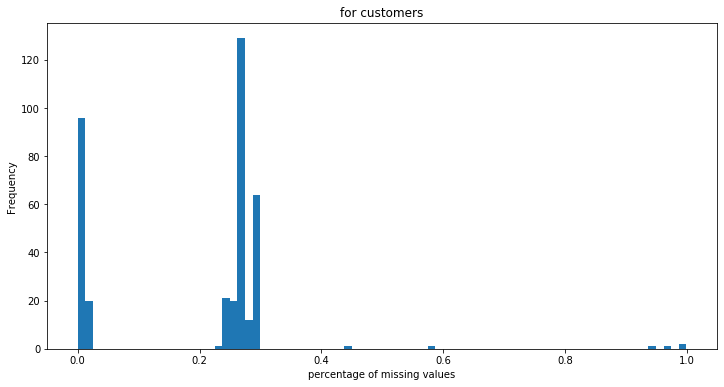

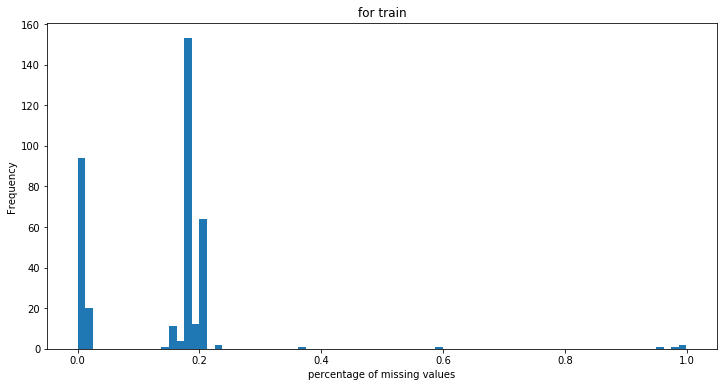

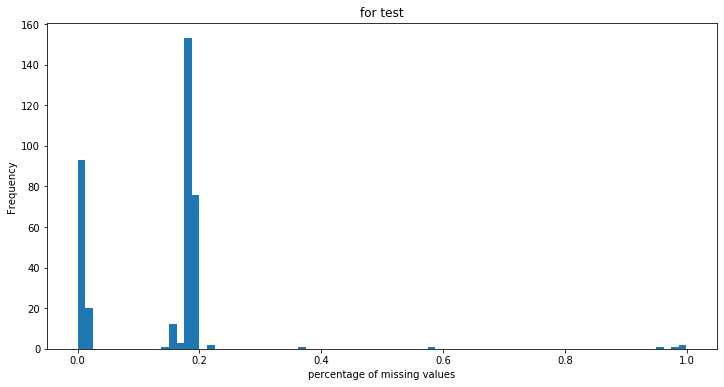

In [13]:
for name, data in datasets.items():
    plt.figure(figsize = (12, 6))
    data_miss = count_na(data)
    count_na(data).plot(kind = 'hist', bins = 80)
    plt.xlabel('percentage of missing values')
    plt.title('for '+name)

del datasets, data #to free up memory

Removing any columns missing with missing data more than 20% makes sense because any more than that might be too much to deal with.
We will use the train dataset to test out and set up our cleaning functions.

In [334]:
missing = count_na(train)
notmiss = list(missing[missing<0.20].index)
clean = train[notmiss]

del missing, notmiss

In [335]:
clean.head(10)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,8.0,15.0,0.0,0.0,1.0,13.0,...,2.0,5.0,2.0,1.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,13.0,1.0,0.0,0.0,2.0,1.0,...,3.0,1.0,2.0,1.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,7.0,0.0,NaN,0.0,0.0,1.0,...,1.0,6.0,4.0,2.0,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,6.0,4.0,0.0,0.0,2.0,4.0,...,4.0,8.0,11.0,11.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,9.0,53.0,0.0,0.0,1.0,44.0,...,4.0,2.0,2.0,1.0,9.0,3.0,3,0,1,3
5,1789,3,1.0,12.0,12.0,17.0,0.0,0.0,1.0,11.0,...,4.0,2.0,1.0,1.0,9.0,2.0,3,0,2,3
6,1795,1,1.0,8.0,8.0,2.0,0.0,0.0,1.0,1.0,...,1.0,6.0,6.0,3.0,9.0,2.0,3,0,2,4
7,1493,2,1.0,13.0,13.0,1.0,0.0,0.0,2.0,1.0,...,0.0,1.0,1.0,1.0,9.0,7.0,3,0,2,4
8,1801,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3,0,2,3
9,1834,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3,0,1,1


In [336]:
clean.dtypes.value_counts()

float64    195
int64       94
object       6
dtype: int64

In [337]:
clean[clean.dtypes[clean.dtypes=='object'].index].head(10)

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
0,5D,5,34,D19_UNBEKANNT,1992-02-10 00:00:00,W
1,5B,5,32,D19_TELKO_MOBILE,1997-05-14 00:00:00,W
2,2D,2,14,D19_LEBENSMITTEL,1995-05-24 00:00:00,O
3,2D,2,14,D19_UNBEKANNT,1992-02-10 00:00:00,W
4,7B,7,41,D19_BEKLEIDUNG_GEH,1992-02-10 00:00:00,W
5,7B,7,41,D19_BUCH_CD,1992-02-10 00:00:00,W
6,4C,4,24,D19_UNBEKANNT,1992-02-10 00:00:00,W
7,5C,5,33,D19_BEKLEIDUNG_GEH,1997-07-18 00:00:00,W
8,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN


These are the few columns that were given a dtype of 'object'. This would mean that most of these should be categorical variables, with the exeption of EINGEFUEGT_AM, which clearly is a columns of dates

In [338]:
set(customers.columns) - set(train.columns)

{'CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'}

In [339]:
set(customers.columns) - set(genpop.columns)

{'CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'}

These 3 columns are only available in the customers dataset. Let's see them in more detail:

MULTI_BUYER     132238
SINGLE_BUYER     59414
Name: CUSTOMER_GROUP, dtype: int64

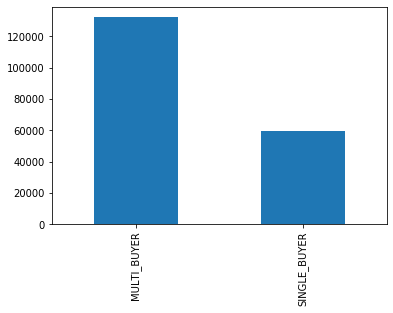

In [22]:
customers.CUSTOMER_GROUP.value_counts(dropna=False).plot( kind = 'bar')
customers.CUSTOMER_GROUP.value_counts(dropna=False)

COSMETIC_AND_FOOD    100860
FOOD                  47382
COSMETIC              43410
Name: PRODUCT_GROUP, dtype: int64

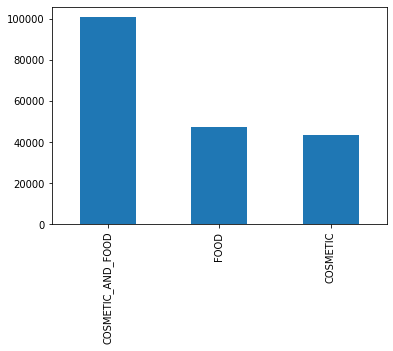

In [23]:
customers.PRODUCT_GROUP.value_counts(dropna=False).plot( kind = 'bar')
customers.PRODUCT_GROUP.value_counts(dropna=False)

0    174356
1     17296
Name: ONLINE_PURCHASE, dtype: int64

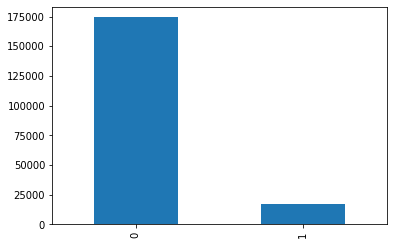

In [24]:
customers.ONLINE_PURCHASE.value_counts(dropna=False).plot( kind = 'bar')
customers.ONLINE_PURCHASE.value_counts(dropna=False)

While this seems very intersting, especially how most of the purchases are made offline, we can't make much use of them in our machine learning later on.

Let's get to know more about the columns were are using

In [25]:
overview = pd.read_excel('./DIAS Information Levels - Attributes 2017.xlsx', index_col=0, header=1)

In [26]:
details = pd.read_excel('./DIAS Attributes - Values 2017.xlsx', index_col=0, header=1)
details = details.dropna(subset=['Attribute'])

In [27]:
overview.shape

(313, 4)

In [28]:
details.shape

(314, 4)

In [29]:
overview.head(10)

,Information level,Attribute,Description,Additional notes
NaN,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the information basis is a consumer survey
NaN,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-reference data
NaN,NaN,ANREDE_KZ,gender,NaN
NaN,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the preferred information and buying channels of consumers,"relating to the preferred information, marketing and buying channels of consumers as well as the..."
NaN,NaN,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative household panel combined via a statistical modell with AZ...
NaN,NaN,FINANZ_SPARER,financial typology: money saver,NaN
NaN,NaN,FINANZ_VORSORGER,financial typology: be prepared,NaN
NaN,NaN,FINANZ_ANLEGER,financial typology: investor,NaN
NaN,NaN,FINANZ_UNAUFFAELLIGER,financial typology: unremarkable,NaN
NaN,NaN,FINANZ_HAUSBAUER,financial typology: main focus is the own house,NaN


In [30]:
details.head(10)

,Attribute,Description,Value,Meaning
NaN,AGER_TYP,best-ager typology,-1,unknown
NaN,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
NaN,ALTER_HH,main age within the household,0,unknown / no main age detectable
NaN,ANREDE_KZ,gender,"-1, 0",unknown
NaN,ANZ_HAUSHALTE_AKTIV,number of households in the building,…,numeric value (typically coded from 1-10)
NaN,ANZ_HH_TITEL,number of academic title holder in building,…,numeric value (typically coded from 1-10)
NaN,ANZ_PERSONEN,number of adult persons in the household,…,numeric value (typically coded from 1-3)
NaN,ANZ_TITEL,number of professional title holder in household,…,numeric value (typically coded from 1-10)
NaN,BALLRAUM,distance to next urban centre,-1,unknown
NaN,BIP_FLAG,business-flag indicating companies in the building,-1,unknown


In [31]:
overview['Information level'].value_counts(dropna=False)

NaN                   303
Household               1
PLZ8                    1
Postcode                1
RR1_ID                  1
Building                1
Community               1
Microcell (RR3_ID)      1
125m x 125m Grid        1
Microcell (RR4_ID)      1
Person                  1
Name: Information level, dtype: int64

Informational Level is too empty to use

In [32]:
details[details.Attribute.isin(overview.Attribute)].shape

(300, 4)

Most of the rows in overview are available in the details dataframe. Let's check out the ones that are different:

In [33]:
details[~details.Attribute.isin(overview.Attribute)] # rows in details but not in overivew

,Attribute,Description,Value,Meaning
NaN,BIP_FLAG,business-flag indicating companies in the building,-1,unknown
NaN,D19_BANKEN_ANZ_12,transaction activity BANKS in the last 12 months,0,no transactions known
NaN,D19_BANKEN_ANZ_24,transaction activity BANKS in the last 24 months,0,no transactions known
NaN,D19_GESAMT_ANZ_12,transaction activity TOTAL POOL in the last 12 months,0,no transactions known
NaN,D19_GESAMT_ANZ_24,transaction activity TOTAL POOL in the last 24 months,0,no transactions known
NaN,D19_LOTTO_RZ,transactional activity based on the product group LOTTO,0,no transaction known
NaN,D19_TELKO_ANZ_12,transaction activity TELCO in the last 12 months,0,no transactions known
NaN,D19_TELKO_ANZ_24,transaction activity TELCO in the last 24 months,0,no transactions known
NaN,D19_VERSAND_ANZ_12,transaction activity MAIL-ORDER in the last 12 months,0,no transactions known
NaN,D19_VERSAND_ANZ_24,transaction activity MAIL-ORDER in the last 24 months,0,no transactions known


In [34]:
overview[~overview.Attribute.isin(details.Attribute)] # rows in overview but not in details

,Information level,Attribute,Description,Additional notes
NaN,NaN,D19_GESAMT_ANZ_12 D19_GESAMT_ANZ_24,transaction activity TOTAL POOL in the last 12 and 24 months,NaN
NaN,NaN,D19_BANKEN_ ANZ_12 D19_BANKEN_ ANZ_24,transaction activity BANKS in the last 12 and 24 months,NaN
NaN,NaN,D19_TELKO_ ANZ_12 D19_TELKO_ ANZ_24,transaction activity TELCO in the last 12 and 24 months,NaN
NaN,NaN,D19_VERSI_ ANZ_12 D19_VERSI_ ANZ_24,transaction activity INSURANCE in the last 12 and 24 months,NaN
NaN,NaN,D19_VERSAND_ ANZ_12 D19_VERSAND_ ANZ_24,transaction activity MAIL-ORDER in the last 12 and 24 months,NaN
NaN,NaN,D19_VERSI_OFFLINE_DATUM,actuality of the last transaction for the segment insurance OFFLINE,NaN
NaN,NaN,D19_VERSI_ONLINE_DATUM,actuality of the last transaction for the segment insurance ONLINE,NaN
NaN,NaN,D19_VERSI_DATUM,actuality of the last transaction for the segment insurance TOTAL,NaN
NaN,NaN,PLZ,postcode,NaN
NaN,NaN,PLZ8,sub-postcode (about 8 PLZ8 make up one PLZ) and \nnew macrocell level (about 500 households),NaN


Both dataframes have a few rows that the other doesn't have. So, it is useful to use them both together.

In [35]:
info = overview.merge(details, how = 'outer').drop(['Information level'],axis=1)
info.head(10)

,Attribute,Description,Additional notes,Value,Meaning
0,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the information basis is a consumer survey,-1,unknown
1,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-reference data,NaN,NaN
2,ANREDE_KZ,gender,NaN,"-1, 0",unknown
3,CJT_GESAMTTYP,Customer-Journey-Typology relating to the preferred information and buying channels of consumers,"relating to the preferred information, marketing and buying channels of consumers as well as the...",NaN,NaN
4,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative household panel combined via a statistical modell with AZ...,-1,unknown
5,FINANZ_SPARER,financial typology: money saver,NaN,-1,unknown
6,FINANZ_VORSORGER,financial typology: be prepared,NaN,-1,unknown
7,FINANZ_ANLEGER,financial typology: investor,NaN,-1,unknown
8,FINANZ_UNAUFFAELLIGER,financial typology: unremarkable,NaN,-1,unknown
9,FINANZ_HAUSBAUER,financial typology: main focus is the own house,NaN,-1,unknown


In [36]:
info.Attribute.duplicated().sum()

50

In [37]:
info = info.drop_duplicates(subset='Attribute')

In [38]:
info.shape

(327, 5)

In [340]:
info_clean = info[info.Attribute.isin(clean.columns)] # focusing on only the columns we will be using
print(info_clean.shape)

(211, 5)


In [341]:
for _, row in info_clean.sort_values('Attribute').iterrows():
    print('{}: {}'.format(row.iloc[0], row.iloc[1]))
    print()
#     break

AGER_TYP: best-ager typology

ALTERSKATEGORIE_GROB: age through prename analysis 

ALTER_HH: main age within the household

ANREDE_KZ: gender

ANZ_HAUSHALTE_AKTIV: number of households known in this building

ANZ_HH_TITEL: number of holders of an academic title in the building

ANZ_PERSONEN: number of persons known in this household

ANZ_TITEL: number of bearers of an academic title within this household

ARBEIT: share of unemployed person in the community

BALLRAUM: distance to the next metropole

CAMEO_DEUG_2015: CAMEO_4.0: uppergroup

CAMEO_DEU_2015: CAMEO_4.0: specific group

CJT_GESAMTTYP: Customer-Journey-Typology relating to the preferred information and buying channels of consumers

D19_BANKEN_ANZ_12: transaction activity BANKS in the last 12 months

D19_BANKEN_ANZ_24: transaction activity BANKS in the last 24 months

D19_BANKEN_DATUM: actuality of the last transaction for the segment banks TOTAL

D19_BANKEN_OFFLINE_DATUM: actuality of the last transaction for the segment banks

After some reading of the above, we can see that most of the columns consist of the following information:

- household
- transactional activity (columns starting with D19)
- Cars (columns starting with KBA13)
- PLZ8 demographics
- financial typology(columns starting with FINANZ)
- mindedness (columns starting with SEMIO)

In [342]:
def print_columns_containing(code):
    perc = (1 - info_clean.Attribute.apply(lambda x: x if code in x else 'other'
                                  ).value_counts(normalize=True).iloc[0]).round(4)*100
    print(code, perc)
    return perc

In [343]:
codes = {}
total = 0
for code in ['D19','KBA13','SEMIO', 'FINANZ']:
    codes[code] = print_columns_containing(code)
    total+= codes[code]
codes['other'] = 100-total

D19 13.74
KBA13 50.71
SEMIO 6.64
FINANZ 3.32


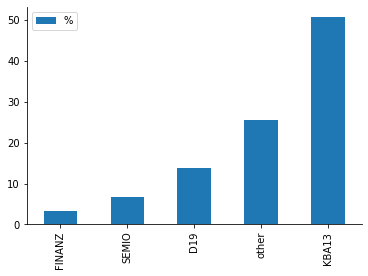

In [344]:
pd.DataFrame(codes, index=['%']).T.sort_values('%').plot(kind='bar')
sns.despine()

We can see that a huge number of the columns (over 50% of train dataset) is comprised of car data.

Transactional data, which is probably more relevant than cars to our project, consists of only 13.74% of the columns available in the train dataset.

In [345]:
clean.isna().sum()[clean.isna().sum()>0].shape

(201,)

We still have 201 columns with missing values that we need to deal with

In [346]:
clean.dtypes.value_counts()

float64    195
int64       94
object       6
dtype: int64

Let's deal with objects first

In [368]:
objects = clean.select_dtypes(include=['object'])
obj_cols = objects.columns
objects.head(10)

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
0,5D,5,34,D19_UNBEKANNT,1992-02-10 00:00:00,W
1,5B,5,32,D19_TELKO_MOBILE,1997-05-14 00:00:00,W
2,2D,2,14,D19_LEBENSMITTEL,1995-05-24 00:00:00,O
3,2D,2,14,D19_UNBEKANNT,1992-02-10 00:00:00,W
4,7B,7,41,D19_BEKLEIDUNG_GEH,1992-02-10 00:00:00,W
5,7B,7,41,D19_BUCH_CD,1992-02-10 00:00:00,W
6,4C,4,24,D19_UNBEKANNT,1992-02-10 00:00:00,W
7,5C,5,33,D19_BEKLEIDUNG_GEH,1997-07-18 00:00:00,W
8,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN


In [369]:
for column in objects.columns:
    print('Number of unique values for {}:'.format(column), objects[column].nunique())
    print()

Number of unique values for CAMEO_DEU_2015: 45

Number of unique values for CAMEO_DEUG_2015: 19

Number of unique values for CAMEO_INTL_2015: 43

Number of unique values for D19_LETZTER_KAUF_BRANCHE: 35

Number of unique values for EINGEFUEGT_AM: 1599

Number of unique values for OST_WEST_KZ: 2



In [370]:
objects.isna().sum() / len(objects)

CAMEO_DEU_2015              0.183604
CAMEO_DEUG_2015             0.183604
CAMEO_INTL_2015             0.183604
D19_LETZTER_KAUF_BRANCHE    0.176528
EINGEFUEGT_AM               0.181020
OST_WEST_KZ                 0.181020
dtype: float64

In [371]:
objects.columns

Index(['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015',
       'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'OST_WEST_KZ'],
      dtype='object')

In [372]:
details[details.Attribute.isin(['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015',
       'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'OST_WEST_KZ'])]

,Attribute,Description,Value,Meaning
NaN,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,-1,unknown
NaN,CAMEO_DEU_2015,CAMEO classification 2015 - detailled classification,1A,Work-Life-Balance
NaN,OST_WEST_KZ,flag indicating the former GDR/FRG,-1,unknown


We didn't get details of all the oclumns, but we can see that CAMEO_DEU is the same as CAMEO_DEUG, so we can just remove one of them. We'll choose to keep CAMEO_DEUG, since it has less unique values.

Similarly, we can't take the date column as it is. Let's try splitting it into Year-Month values:

In [373]:
objects['EINGEFUEGT_AM'].apply(lambda date: '-'.join(str(date).split('-')[0:2])).nunique()

262

262 are too many unique values - so we have to group them into just Years instead:

In [374]:
objects['date'] = objects['EINGEFUEGT_AM'].apply(lambda date: date.split('-')[0] if  date is not np.nan else date)
objects.date.nunique()

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


25

In [375]:
objects.date.value_counts().sort_index()

1991        1
1992    26425
1993     1188
1994     1398
1995     1900
1996     1350
1997      866
1998      154
1999       33
2000      218
2001       59
2002      121
2003      333
2004      223
2005      350
2006      144
2007       92
2008       73
2009       65
2010       29
2011       41
2012       47
2013       29
2014       30
2015       16
Name: date, dtype: int64

It appears this data is split up over 26 years, with only 1 values in the first year (1991), and last year being 2015.

In [376]:
objects = objects.drop(['CAMEO_DEU_2015','EINGEFUEGT_AM'], axis=1)

In [377]:
objects.head(10)

,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,OST_WEST_KZ,date
0,5,34,D19_UNBEKANNT,W,1992
1,5,32,D19_TELKO_MOBILE,W,1997
2,2,14,D19_LEBENSMITTEL,O,1995
3,2,14,D19_UNBEKANNT,W,1992
4,7,41,D19_BEKLEIDUNG_GEH,W,1992
5,7,41,D19_BUCH_CD,W,1992
6,4,24,D19_UNBEKANNT,W,1992
7,5,33,D19_BEKLEIDUNG_GEH,W,1997
8,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN


In [378]:
objects.mode().iloc[0]

CAMEO_DEUG_2015                         6
CAMEO_INTL_2015                        24
D19_LETZTER_KAUF_BRANCHE    D19_UNBEKANNT
OST_WEST_KZ                             W
date                                 1992
Name: 0, dtype: object

In [379]:
objects.memory_usage(index=False, deep=True)

CAMEO_DEUG_2015             1635486
CAMEO_INTL_2015             1645513
D19_LETZTER_KAUF_BRANCHE    2766207
OST_WEST_KZ                 2289594
date                        2395149
dtype: int64

In [380]:
objects[['CAMEO_DEUG_2015','CAMEO_INTL_2015','date']] = \
objects[['CAMEO_DEUG_2015','CAMEO_INTL_2015','date']].apply(lambda df: pd.to_numeric(df, errors='coerce'))

In [381]:
objects = objects.fillna(objects.mode().iloc[0]).astype('category')

In [382]:
objects.memory_usage(index=False, deep=True)

CAMEO_DEUG_2015             43354
CAMEO_INTL_2015             43770
D19_LETZTER_KAUF_BRANCHE    46737
OST_WEST_KZ                 43158
date                        43802
dtype: int64

By changing from object to category dtype, we have drastically reduced the amount of memeory used

In [383]:
objects.head(10)

,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,OST_WEST_KZ,date
0,5.0,34.0,D19_UNBEKANNT,W,1992.0
1,5.0,32.0,D19_TELKO_MOBILE,W,1997.0
2,2.0,14.0,D19_LEBENSMITTEL,O,1995.0
3,2.0,14.0,D19_UNBEKANNT,W,1992.0
4,7.0,41.0,D19_BEKLEIDUNG_GEH,W,1992.0
5,7.0,41.0,D19_BUCH_CD,W,1992.0
6,4.0,24.0,D19_UNBEKANNT,W,1992.0
7,5.0,33.0,D19_BEKLEIDUNG_GEH,W,1997.0
8,6.0,24.0,D19_UNBEKANNT,W,1992.0
9,6.0,24.0,D19_UNBEKANNT,W,1992.0


In [384]:
objects.isna().sum()

CAMEO_DEUG_2015             0
CAMEO_INTL_2015             0
D19_LETZTER_KAUF_BRANCHE    0
OST_WEST_KZ                 0
date                        0
dtype: int64

Good. Now that there are no more empty values. We need to change our categorical values to numbers

In [385]:
objects.CAMEO_DEUG_2015.value_counts(dropna=False)

6.0    13262
4.0     5131
8.0     5010
2.0     4703
3.0     4423
7.0     3064
5.0     2531
9.0     2460
1.0     2378
Name: CAMEO_DEUG_2015, dtype: int64

Need to remove those .0s

In [386]:
def remove_point0(df, col):
    return df[col].apply(lambda x: str(x).split('.')[0])

In [388]:
for col in objects.columns:
    objects[col] = remove_point0(objects, col)

In [390]:
objects.head()

,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,OST_WEST_KZ,date
0,5,34,D19_UNBEKANNT,W,1992
1,5,32,D19_TELKO_MOBILE,W,1997
2,2,14,D19_LEBENSMITTEL,O,1995
3,2,14,D19_UNBEKANNT,W,1992
4,7,41,D19_BEKLEIDUNG_GEH,W,1992


Now we're ready to change them to dummies!

In [391]:
objects_touse = pd.get_dummies(objects, drop_first=True)

In [392]:
del objects

In [393]:
objects_touse.head()

,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,CAMEO_INTL_2015_13,CAMEO_INTL_2015_14,...,date_2006,date_2007,date_2008,date_2009,date_2010,date_2011,date_2012,date_2013,date_2014,date_2015
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now that we're done with the objects, time to look at the numeric columns

In [394]:
numbers = clean.loc[:, ~clean.columns.isin(obj_cols)]

In [395]:
numbers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,8.0,15.0,0.0,0.0,1.0,13.0,...,2.0,5.0,2.0,1.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,13.0,1.0,0.0,0.0,2.0,1.0,...,3.0,1.0,2.0,1.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,7.0,0.0,NaN,0.0,0.0,1.0,...,1.0,6.0,4.0,2.0,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,6.0,4.0,0.0,0.0,2.0,4.0,...,4.0,8.0,11.0,11.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,9.0,53.0,0.0,0.0,1.0,44.0,...,4.0,2.0,2.0,1.0,9.0,3.0,3,0,1,3


In [396]:
numbers['LNR'].nunique()

42962

In [397]:
numbers.shape

(42962, 289)

LNR is unique to each row so it is clearly an ID number. Since ids are meaningless to us, we'll remove it

In [398]:
numbers = numbers.drop('LNR',axis=1)

In [399]:
numbers.memory_usage(index=False)

AGER_TYP                343696
AKT_DAT_KL              343696
ALTER_HH                343696
ALTERSKATEGORIE_FEIN    343696
ANZ_HAUSHALTE_AKTIV     343696
                         ...  
WOHNLAGE                343696
ZABEOTYP                343696
RESPONSE                343696
ANREDE_KZ               343696
ALTERSKATEGORIE_GROB    343696
Length: 288, dtype: int64

We can't do much with such a huge memory size, so let's reduce it. But first, we'll take a look at the unique numbers.

In [400]:
unis = numbers.nunique()

In [401]:
unis.head(20)

AGER_TYP                        5
AKT_DAT_KL                      9
ALTER_HH                       20
ALTERSKATEGORIE_FEIN           25
ANZ_HAUSHALTE_AKTIV           175
ANZ_HH_TITEL                   15
ANZ_KINDER                      7
ANZ_PERSONEN                   14
ANZ_STATISTISCHE_HAUSHALTE    173
ANZ_TITEL                       3
ARBEIT                          6
BALLRAUM                        7
CJT_GESAMTTYP                   6
CJT_KATALOGNUTZER               5
CJT_TYP_1                       5
CJT_TYP_2                       5
CJT_TYP_3                       5
CJT_TYP_4                       5
CJT_TYP_5                       5
CJT_TYP_6                       5
dtype: int64

In [403]:
numbers.shape

(42962, 288)

In [404]:
unis[unis<20].shape #seeing without outliers

(278,)

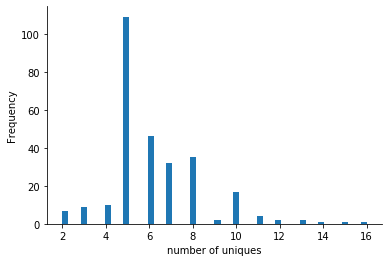

In [405]:
unis[unis<20].plot(kind='hist',bins=50)
plt.xlabel('number of uniques')
sns.despine()

We can see that a large number of our supposedly numeric columns have only 5 or less unique numbers. This could suggest that these columns might actually be categorical instead. Let's check:

In [406]:
overview[overview.Attribute.isin(unis[unis==5].index)].tail(10)

,Information level,Attribute,Description,Additional notes
NaN,NaN,KBA13_VORB_0,share of cars with no preowner - PLZ8,NaN
NaN,NaN,KBA13_VORB_1,share of cars with 1 preowner - PLZ8,NaN
NaN,NaN,KBA13_VORB_1_2,share of cars with 1 or 2 preowner - PLZ8,NaN
NaN,NaN,KBA13_VORB_2,share of cars with 2 preowner - PLZ8,NaN
NaN,NaN,KBA13_VW,share of VOLKSWAGEN within the PLZ8,NaN
NaN,NaN,PLZ8_ANTG1,number of 1-2 family houses in the PLZ8,NaN
NaN,NaN,PLZ8_ANTG2,number of 3-5 family houses in the PLZ8,NaN
NaN,NaN,PLZ8_BAUMAX,most common building-type within the PLZ8,NaN
NaN,NaN,PLZ8_HHZ,number of households within the PLZ8,NaN
NaN,NaN,PLZ8_GBZ,number of buildings within the PLZ8,NaN


Looking at it here, it seems that assumption was not exactly correct. For example, for number of family houses, 3 is more 2, which is more than 1. That can't be a categorical variable and should stay as numeric to keep that kind of information. The kind that says that some people have more than others. You can't do that with a categorical variable. So, let's move on.

In [407]:
del unis

In [409]:
def reduce_memory_nums(df):
    for col in df.columns:
#         print(col)

        mx = df[col].max()
        mn = df[col].min()

        if mn >= 0:
            if mx < 255:
                df[col] = df[col].astype(np.uint8, errors='ignore')
            elif mx < 65535:
                df[col] = df[col].astype(np.uint16, errors='ignore')
            elif mx < 4294967295:
                df[col] = df[col].astype(np.uint32, errors='ignore')
            else:
                df[col] = df[col].astype(np.uint64, errors='ignore')
        else:
            if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                df[col] = df[col].astype(np.int8, errors='ignore')
            elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                df[col] = df[col].astype(np.int16, errors='ignore')
            elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                df[col] = df[col].astype(np.int32, errors='ignore')
            elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                df[col] = df[col].astype(np.int64, errors='ignore')
    return df

In [408]:
#         df[col] = df[col].apply(lambda s: pd.to_numeric(s, errors='coerce'))
#         df[col] = df[col].fillna(df[col].median())

In [413]:
numbers.memory_usage(index=False)

AGER_TYP                343696
AKT_DAT_KL              343696
ALTER_HH                343696
ALTERSKATEGORIE_FEIN    343696
ANZ_HAUSHALTE_AKTIV     343696
                         ...  
WOHNLAGE                343696
ZABEOTYP                343696
RESPONSE                343696
ANREDE_KZ               343696
ALTERSKATEGORIE_GROB    343696
Length: 288, dtype: int64

In [414]:
numbers = reduce_memory_nums(numbers)

In [415]:
numbers.memory_usage(index=False)

AGER_TYP                 42962
AKT_DAT_KL              343696
ALTER_HH                343696
ALTERSKATEGORIE_FEIN    343696
ANZ_HAUSHALTE_AKTIV     343696
                         ...  
WOHNLAGE                343696
ZABEOTYP                 42962
RESPONSE                 42962
ANREDE_KZ                42962
ALTERSKATEGORIE_GROB     42962
Length: 288, dtype: int64

In [417]:
numbers.isna().sum().sum()

1387396

In [420]:
# numbers = numbers.apply(lambda s: pd.to_numeric(s, errors='coerce'))
numbers = numbers.fillna(numbers.median().iloc[0])

In [421]:
numbers.isna().sum().sum()

0

Now we have no more missing values with numbers.

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [6]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
mailout_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [8]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [9]:
mailout_test.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4
